# Prediction using can yo

Credits to https://www.kaggle.com/code/tarundirector/histology-eda-spotnet-visual-spatial-dl . Kudos for the amazing notebook!



In [1]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
    -f https://data.pyg.org/whl/torch-2.0.0+cu118.html


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.5/886.5 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.7 MB/s eta 0:00:00


In [2]:
nb_type = "Submission"

In [3]:
# --- Core Python Libraries ---
import os
import math

# --- Data Processing ---
import numpy as np
import pandas as pd
import h5py

# --- Plotting ---
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle

# --- Deep Learning: PyTorch & TorchVision ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# --- Metrics ---
from scipy.stats import spearmanr

In [4]:
from torch_geometric.nn import GATConv
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data
import torch.nn.functional as F

class SpotGNN(torch.nn.Module):
    def __init__(self, in_dim=640, hidden_dim=256, out_dim=35):  # 512+128 if using ResNet34
        super().__init__()
        self.gat1 = GATConv(in_dim, hidden_dim, heads=4, concat=True)
        self.gat2 = GATConv(4 * hidden_dim, out_dim, heads=1)

    def forward(self, x, edge_index):
        x = F.relu(self.gat1(x, edge_index))
        return self.gat2(x, edge_index)


def extract_spotnet_features(model, features):
    model.eval()
    all_feats = []
    with torch.no_grad():
        for img5, coord2 in features:
            img5 = img5.unsqueeze(0).to(DEVICE)
            coord2 = coord2.unsqueeze(0).to(DEVICE)
            f_img = model.cnn(img5)
            f_coord = model.coord_mlp(model.coord_ff(coord2))
            feat = torch.cat([f_img, f_coord], dim=1).squeeze(0).cpu()
            all_feats.append(feat)
    return torch.stack(all_feats)  # [N, feature_dim]


def build_features_and_graph(df_slide, images, transform, k=6):
    features = []
    labels = []
    coords = []
    slide = df_slide["slide"].iloc[0]
    img = images[slide]
    h, w, _ = img.shape

    for i, row in df_slide.iterrows():
        x, y = row["x"], row["y"]
        x_norm, y_norm = row["x_norm"], row["y_norm"]
        lbl = torch.tensor(row["label"], dtype=torch.float32)

        half = PATCH_SIZE // 2
        y0, y1 = max(0,y-half), min(h,y+half)
        x0, x1 = max(0,x-half), min(w,x+half)
        patch = img[y0:y1, x0:x1]
        pad_y = (max(0,half-y), max(0,(y+half)-h))
        pad_x = (max(0,half-x), max(0,(x+half)-w))
        patch = np.pad(patch, (pad_y, pad_x, (0,0)), mode='constant', constant_values=0)
        img_t = transform(patch)

        x_map = torch.full((1, PATCH_SIZE, PATCH_SIZE), x_norm)
        y_map = torch.full((1, PATCH_SIZE, PATCH_SIZE), y_norm)
        img5 = torch.cat([img_t, x_map, y_map], dim=0)

        coord2 = torch.tensor([x_norm, y_norm], dtype=torch.float32)

        features.append((img5, coord2))
        labels.append(lbl)
        coords.append([x_norm, y_norm])

    coords = np.array(coords)
    nbrs = NearestNeighbors(n_neighbors=k).fit(coords)
    edge_index = nbrs.kneighbors_graph(coords).tocoo()
    edge_index = torch.tensor(np.vstack([edge_index.row, edge_index.col]), dtype=torch.long)

    return features, torch.stack(labels), edge_index


def train_spotgnn_for_fold(fold, df_fold, images, transform, model_path, save_path="gnn_fold{}.pt", epochs=20, k=6):
    print(f"\n🔁 Training SpotGNN for fold {fold}")
    
    # Load SpotNet
    spotnet = SpotNet(num_types=NUM_CELL_TYPES).to(DEVICE)
    spotnet.load_state_dict(torch.load(model_path.format(fold)))
    spotnet.eval()

    # Build features and graph
    features, labels, edge_index = build_features_and_graph(df_fold, images, transform, k=k)
    x_all = extract_spotnet_features(spotnet, features).to(DEVICE)
    labels = labels.to(DEVICE)
    edge_index = edge_index.to(DEVICE)

    # Train GNN
    gnn = SpotGNN(in_dim=x_all.shape[1], out_dim=NUM_CELL_TYPES).to(DEVICE)
    optimizer = torch.optim.Adam(gnn.parameters(), lr=1e-3)

    for epoch in range(1, epochs + 1):
        gnn.train()
        preds = gnn(x_all, edge_index)
        loss = F.mse_loss(preds, labels)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        print(f"[Fold {fold} | Epoch {epoch}] GNN Loss: {loss.item():.4f}")

    # Save GNN
    torch.save(gnn.state_dict(), save_path.format(fold))
    print(f"✅ Saved GNN model for fold {fold} to {save_path.format(fold)}")


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

In [5]:
def forward_graph_spotnet(model, gnn, features, edge_index):
    """
    Apply SpotNet to extract features, then GNN for refinement.
    """
    model.eval(); gnn.eval()
    with torch.no_grad():
        xs = []
        for img5, coord2 in features:
            img5 = img5.unsqueeze(0).to(DEVICE)
            coord2 = coord2.unsqueeze(0).to(DEVICE)
            feat = model.cnn(img5)
            coord_feat = model.coord_mlp(model.coord_ff(coord2))
            x = torch.cat([feat, coord_feat], dim=1)
            xs.append(x.squeeze(0).cpu())
        x_all = torch.stack(xs)
        preds = gnn(x_all.to(DEVICE), edge_index.to(DEVICE))
    return preds.cpu()


In [6]:
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors

def build_slide_graph(df_slide, images, transform, k=6):
    """
    Build a graph of spots within a single slide.
    Each node has img5, coord2, and label.
    """
    features = []
    labels = []
    coords = []
    
    slide = df_slide["slide"].iloc[0]
    img = images[slide]
    h, w, _ = img.shape

    for i, row in df_slide.iterrows():
        x, y = row["x"], row["y"]
        x_norm, y_norm = row["x_norm"], row["y_norm"]
        lbl = torch.tensor(row["label"], dtype=torch.float32)

        # extract patch
        half = PATCH_SIZE // 2
        y0, y1 = max(0,y-half), min(h,y+half)
        x0, x1 = max(0,x-half), min(w,x+half)
        patch = img[y0:y1, x0:x1]
        pad_y = (max(0,half-y), max(0,(y+half)-h))
        pad_x = (max(0,half-x), max(0,(x+half)-w))
        patch = np.pad(patch, (pad_y, pad_x, (0,0)), mode='constant', constant_values=0)
        img_t = transform(patch)

        x_map = torch.full((1, PATCH_SIZE, PATCH_SIZE), x_norm)
        y_map = torch.full((1, PATCH_SIZE, PATCH_SIZE), y_norm)
        img5 = torch.cat([img_t, x_map, y_map], dim=0)

        coord2 = torch.tensor([x_norm, y_norm], dtype=torch.float32)

        features.append((img5, coord2))
        labels.append(lbl)
        coords.append([x_norm, y_norm])

    coords = np.array(coords)
    nbrs = NearestNeighbors(n_neighbors=k).fit(coords)
    edge_index = nbrs.kneighbors_graph(coords).tocoo()
    edge_index = torch.tensor(np.vstack([edge_index.row, edge_index.col]), dtype=torch.long)

    return features, labels, edge_index


In [7]:
# Trnasform images and spots into a dataframe. Used for implemeting cross-validation more easily
def build_spot_dataframe(images, spots, shifts):
    rows = []
    for slide in images:
        img = images[slide]
        h, w, _ = img.shape
        dx, dy = shifts.get(slide, (0, 0))
        for i, spot in enumerate(spots[slide]):
            x, y = spot["x"] + dx, spot["y"] + dy
            x_norm, y_norm = x / w, y / h
            label = [spot[f"C{j}"] for j in range(1, NUM_CELL_TYPES + 1)]
            rows.append({
                "slide": slide,
                "x": int(x),
                "y": int(y),
                "x_norm": x_norm,
                "y_norm": y_norm,
                "label": label
            })
    return pd.DataFrame(rows)



In [8]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import os, h5py, math
import numpy as np, pandas as pd
import torch
import torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# --- 1) Load data dicts ---
file_path = "/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5"
with h5py.File(file_path, "r") as f:
    train_images = {k: np.array(v) for k,v in f["images/Train"].items()}
    train_spots  = {k: np.array(v) for k,v in f["spots/Train"].items()}
    test_images  = {k: np.array(v) for k,v in f["images/Test"].items()}
    test_spots   = {k: np.array(v) for k,v in f["spots/Test"].items()}

# --- 2) Slide-specific pixel shifts (as before) ---
shifts = {
    "S_1":(-65,-70), "S_2":(-65,-70),
    "S_3":(-15,0),   "S_4":(0,0),
    "S_5":(0,0),     "S_6":(-30,0),
    # S_7: test → defaults to (0,0)
}

# --- 3) Hyperparams & Transforms ---
PATCH_SIZE     = 384
BATCH_SIZE     = 16
LR             = 1e-4
EPOCHS         = 20
NUM_CELL_TYPES = 35
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_tfm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.RandomAffine(10, scale=(0.9,1.1)),
    transforms.Resize((PATCH_SIZE, PATCH_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
eval_tfm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((PATCH_SIZE, PATCH_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# --- 4) Dataset: returns (img5chan, coord2, label) or (img5chan, coord2, idx) ---
class HistologyDatasetFromDF(Dataset):
    def __init__(self, df, images, transform):
        self.df = df.reset_index(drop=True)
        self.images = images
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        slide = row["slide"]
        x, y = row["x"], row["y"]
        x_norm, y_norm = row["x_norm"], row["y_norm"]
        label = row["label"]

        img = self.images[slide]
        h, w, _ = img.shape
        half = PATCH_SIZE // 2

        # crop with padding
        y0, y1 = max(0, y-half), min(h, y+half)
        x0, x1 = max(0, x-half), min(w, x+half)
        patch = img[y0:y1, x0:x1]
        pad_y = (max(0, half - y), max(0, (y + half) - h))
        pad_x = (max(0, half - x), max(0, (x + half) - w))
        patch = np.pad(patch, (pad_y, pad_x, (0, 0)), mode='constant', constant_values=0)
        img_t = self.transform(patch)

        x_map = torch.full((1, PATCH_SIZE, PATCH_SIZE), x_norm)
        y_map = torch.full((1, PATCH_SIZE, PATCH_SIZE), y_norm)
        img5 = torch.cat([img_t, x_map, y_map], dim=0)

        coord2 = torch.tensor([x_norm, y_norm], dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        return img5, coord2, label


# --- 5) Fourier MLP on 2-D coords ---
class FourierFeature(nn.Module):
    def __init__(self, in_dim=2, mapping_size=64, scale=10.0):
        super().__init__()
        B = torch.randn(mapping_size, in_dim) * scale
        self.register_buffer("B", B)

    def forward(self, x):
        x_proj = 2*math.pi * x @ self.B.t()        # [B,64]
        return torch.cat([x_proj.sin(), x_proj.cos()], dim=-1)  # [B,128]

# --- 6) Hybrid CoordConv + CoordMLP SpotNet ---
class SpotNet(nn.Module):
    def __init__(self, num_types=35, backbone="resnet34"):
        super().__init__()
        # --- Image tower with CoordConv(5→64) ---
        if backbone=="resnet34":
            cnn = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        else:
            cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        old1 = cnn.conv1
        new1 = nn.Conv2d(5, old1.out_channels,
                         kernel_size=old1.kernel_size,
                         stride=old1.stride,
                         padding=old1.padding,
                         bias=old1.bias is not None)
        with torch.no_grad():
            new1.weight[:,:3] = old1.weight  # copy RGB
            new1.weight[:,3:] = old1.weight[:,:2].mean(dim=1,keepdim=True)*0.0
        cnn.conv1 = new1
        dim = cnn.fc.in_features
        cnn.fc = nn.Identity()
        self.cnn = cnn

        # --- Coord MLP tower ---
        self.coord_ff  = FourierFeature(in_dim=2, mapping_size=64, scale=10.0)
        self.coord_mlp = nn.Sequential(
            nn.Linear(128,256), nn.ReLU(),
            nn.Linear(256,128), nn.ReLU()
        )

        # --- Fusion head ---
        self.head = nn.Sequential(
            nn.Linear(dim + 128, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 256),       nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, num_types)
        )

    def forward(self, img5, coord2):
        f = self.cnn(img5)              # [B, dim]
        h = self.coord_ff(coord2)       # [B,128]
        h = self.coord_mlp(h)           # [B,128]
        x = torch.cat([f, h], dim=1)    # [B, dim+128]
        return self.head(x)             # [B,35]

# --- 7) Loss & validation ---
def spearman_loss(pred, target):
    rho=[]
    p_np=pred.detach().cpu().numpy()
    t_np=target.detach().cpu().numpy()
    for p,t in zip(p_np,t_np):
        r = spearmanr(p,t)[0]
        if not np.isnan(r): rho.append(r)
    return 1 - np.mean(rho)

def valid_loop(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for img5, coord2, y in loader:
            img5, coord2 = img5.to(DEVICE), coord2.to(DEVICE)
            preds.append(model(img5, coord2).cpu())
            trues.append(y)
    preds = torch.cat(preds); trues = torch.cat(trues)
    return spearman_loss(preds, trues)

In [9]:
from sklearn.model_selection import train_test_split

#df_spots = build_spot_dataframe(train_images, train_spots, shifts)
#df_train, df_val = train_test_split(df_spots, test_size=0.15, random_state=42, stratify=df_spots["slide"])


🔁 Fold 1


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 225MB/s]


🚀 Starting training for fold 1
[Fold 1 | Epoch 1] Train-Loss: 0.9991  Val-Spearman: 0.4984
✅ Saved best model for fold 1 (Spearman=0.4984)
[Fold 1 | Epoch 2] Train-Loss: 0.7549  Val-Spearman: 0.5544
✅ Saved best model for fold 1 (Spearman=0.5544)
[Fold 1 | Epoch 3] Train-Loss: 0.6475  Val-Spearman: 0.5585
✅ Saved best model for fold 1 (Spearman=0.5585)
[Fold 1 | Epoch 4] Train-Loss: 0.5537  Val-Spearman: 0.5714
✅ Saved best model for fold 1 (Spearman=0.5714)
[Fold 1 | Epoch 5] Train-Loss: 0.4906  Val-Spearman: 0.5160
[Fold 1 | Epoch 6] Train-Loss: 0.4523  Val-Spearman: 0.6105
✅ Saved best model for fold 1 (Spearman=0.6105)
[Fold 1 | Epoch 7] Train-Loss: 0.3982  Val-Spearman: 0.5954
[Fold 1 | Epoch 8] Train-Loss: 0.3589  Val-Spearman: 0.6281
✅ Saved best model for fold 1 (Spearman=0.6281)
[Fold 1 | Epoch 9] Train-Loss: 0.3241  Val-Spearman: 0.6386
✅ Saved best model for fold 1 (Spearman=0.6386)
[Fold 1 | Epoch 10] Train-Loss: 0.3292  Val-Spearman: 0.6449
✅ Saved best model for fold 1 (S

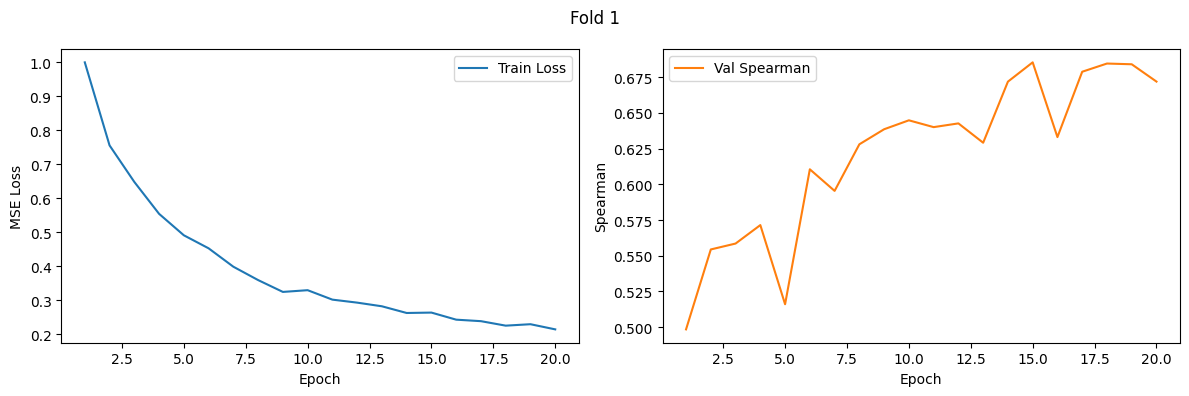


✅ Fold 1 complete. Best Val Spearman = 0.6855

🔁 Fold 2
🚀 Starting training for fold 2
[Fold 2 | Epoch 1] Train-Loss: 1.0185  Val-Spearman: 0.5121
✅ Saved best model for fold 2 (Spearman=0.5121)
[Fold 2 | Epoch 2] Train-Loss: 0.7938  Val-Spearman: 0.5486
✅ Saved best model for fold 2 (Spearman=0.5486)
[Fold 2 | Epoch 3] Train-Loss: 0.6752  Val-Spearman: 0.5679
✅ Saved best model for fold 2 (Spearman=0.5679)
[Fold 2 | Epoch 4] Train-Loss: 0.5637  Val-Spearman: 0.6070
✅ Saved best model for fold 2 (Spearman=0.6070)
[Fold 2 | Epoch 5] Train-Loss: 0.5088  Val-Spearman: 0.5993
[Fold 2 | Epoch 6] Train-Loss: 0.4328  Val-Spearman: 0.6286
✅ Saved best model for fold 2 (Spearman=0.6286)
[Fold 2 | Epoch 7] Train-Loss: 0.4002  Val-Spearman: 0.6470
✅ Saved best model for fold 2 (Spearman=0.6470)
[Fold 2 | Epoch 8] Train-Loss: 0.3847  Val-Spearman: 0.6530
✅ Saved best model for fold 2 (Spearman=0.6530)
[Fold 2 | Epoch 9] Train-Loss: 0.3693  Val-Spearman: 0.6641
✅ Saved best model for fold 2 (Spear

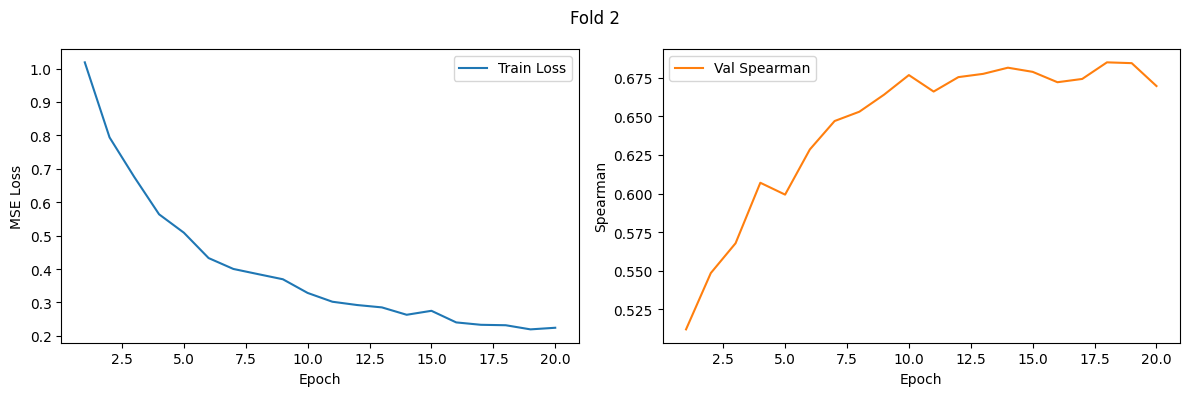


✅ Fold 2 complete. Best Val Spearman = 0.6850

🔁 Fold 3
🚀 Starting training for fold 3
[Fold 3 | Epoch 1] Train-Loss: 1.0123  Val-Spearman: 0.5078
✅ Saved best model for fold 3 (Spearman=0.5078)
[Fold 3 | Epoch 2] Train-Loss: 0.7821  Val-Spearman: 0.5604
✅ Saved best model for fold 3 (Spearman=0.5604)
[Fold 3 | Epoch 3] Train-Loss: 0.6737  Val-Spearman: 0.5065
[Fold 3 | Epoch 4] Train-Loss: 0.6019  Val-Spearman: 0.6032
✅ Saved best model for fold 3 (Spearman=0.6032)
[Fold 3 | Epoch 5] Train-Loss: 0.5350  Val-Spearman: 0.6027
[Fold 3 | Epoch 6] Train-Loss: 0.4565  Val-Spearman: 0.5816
[Fold 3 | Epoch 7] Train-Loss: 0.4129  Val-Spearman: 0.6400
✅ Saved best model for fold 3 (Spearman=0.6400)
[Fold 3 | Epoch 8] Train-Loss: 0.3760  Val-Spearman: 0.6356
[Fold 3 | Epoch 9] Train-Loss: 0.3809  Val-Spearman: 0.6591
✅ Saved best model for fold 3 (Spearman=0.6591)
[Fold 3 | Epoch 10] Train-Loss: 0.3403  Val-Spearman: 0.6914
✅ Saved best model for fold 3 (Spearman=0.6914)
[Fold 3 | Epoch 11] Tra

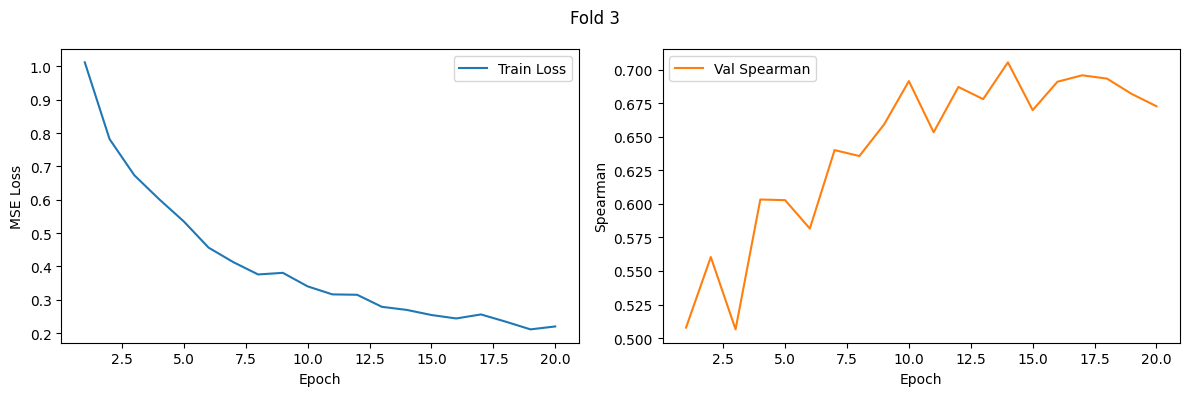


✅ Fold 3 complete. Best Val Spearman = 0.7053

🔁 Fold 4
🚀 Starting training for fold 4
[Fold 4 | Epoch 1] Train-Loss: 1.0088  Val-Spearman: 0.5272
✅ Saved best model for fold 4 (Spearman=0.5272)
[Fold 4 | Epoch 2] Train-Loss: 0.7650  Val-Spearman: 0.4928
[Fold 4 | Epoch 3] Train-Loss: 0.6244  Val-Spearman: 0.5143
[Fold 4 | Epoch 4] Train-Loss: 0.4845  Val-Spearman: 0.6051
✅ Saved best model for fold 4 (Spearman=0.6051)
[Fold 4 | Epoch 5] Train-Loss: 0.4562  Val-Spearman: 0.6280
✅ Saved best model for fold 4 (Spearman=0.6280)
[Fold 4 | Epoch 6] Train-Loss: 0.4047  Val-Spearman: 0.6631
✅ Saved best model for fold 4 (Spearman=0.6631)
[Fold 4 | Epoch 7] Train-Loss: 0.3738  Val-Spearman: 0.6196
[Fold 4 | Epoch 8] Train-Loss: 0.3646  Val-Spearman: 0.6673
✅ Saved best model for fold 4 (Spearman=0.6673)
[Fold 4 | Epoch 9] Train-Loss: 0.3185  Val-Spearman: 0.6803
✅ Saved best model for fold 4 (Spearman=0.6803)
[Fold 4 | Epoch 10] Train-Loss: 0.3031  Val-Spearman: 0.6574
[Fold 4 | Epoch 11] Tra

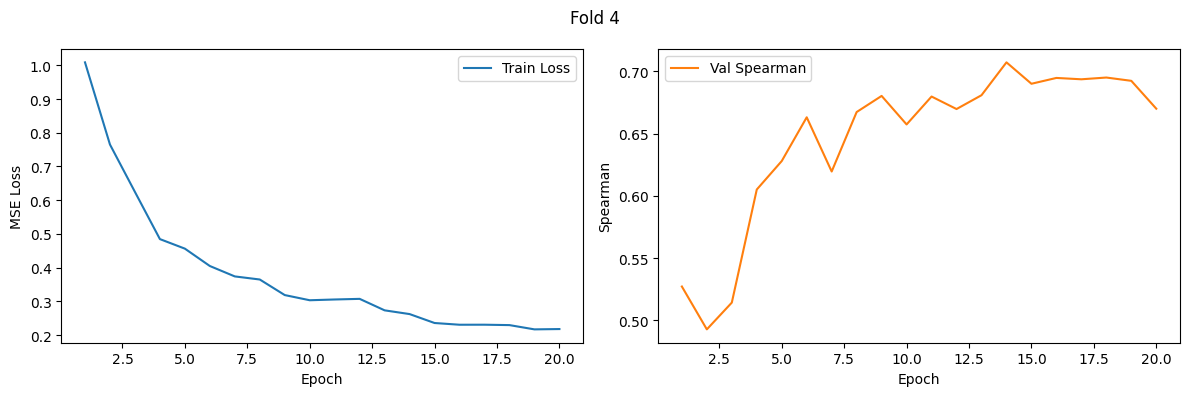


✅ Fold 4 complete. Best Val Spearman = 0.7072

🔁 Fold 5
🚀 Starting training for fold 5
[Fold 5 | Epoch 1] Train-Loss: 1.0055  Val-Spearman: 0.4286
✅ Saved best model for fold 5 (Spearman=0.4286)
[Fold 5 | Epoch 2] Train-Loss: 0.7775  Val-Spearman: 0.4458
✅ Saved best model for fold 5 (Spearman=0.4458)
[Fold 5 | Epoch 3] Train-Loss: 0.6633  Val-Spearman: 0.5274
✅ Saved best model for fold 5 (Spearman=0.5274)
[Fold 5 | Epoch 4] Train-Loss: 0.5779  Val-Spearman: 0.5675
✅ Saved best model for fold 5 (Spearman=0.5675)
[Fold 5 | Epoch 5] Train-Loss: 0.4954  Val-Spearman: 0.5975
✅ Saved best model for fold 5 (Spearman=0.5975)
[Fold 5 | Epoch 6] Train-Loss: 0.4685  Val-Spearman: 0.6227
✅ Saved best model for fold 5 (Spearman=0.6227)
[Fold 5 | Epoch 7] Train-Loss: 0.4088  Val-Spearman: 0.6143
[Fold 5 | Epoch 8] Train-Loss: 0.3663  Val-Spearman: 0.6246
✅ Saved best model for fold 5 (Spearman=0.6246)
[Fold 5 | Epoch 9] Train-Loss: 0.3368  Val-Spearman: 0.6383
✅ Saved best model for fold 5 (Spear

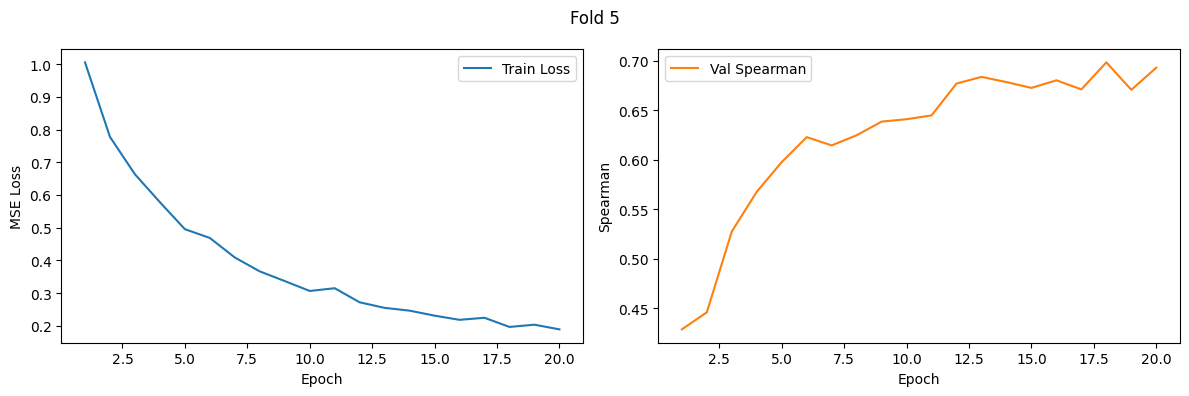


✅ Fold 5 complete. Best Val Spearman = 0.6982


In [10]:
nb_type = "Train"
from sklearn.model_selection import StratifiedKFold
df_folds = []
if nb_type == "Train":
    # Step 1: Build spot-level DataFrame
    df_spots = build_spot_dataframe(train_images, train_spots, shifts)

    # Step 2: Initialize k-fold splitter
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(skf.split(df_spots, df_spots["slide"])):
        print(f"\n🔁 Fold {fold + 1}")
        df_train = df_spots.iloc[train_idx].reset_index(drop=True)
        df_val   = df_spots.iloc[val_idx].reset_index(drop=True)
        df_folds.append((df_train, df_val))


        ds_tr = HistologyDatasetFromDF(df_train, train_images, train_tfm)
        ds_va = HistologyDatasetFromDF(df_val, train_images, eval_tfm)

        loader_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
        loader_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

        model     = SpotNet(num_types=NUM_CELL_TYPES).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=LR)
        criterion = nn.MSELoss()

        history, best_spear = {"train_loss":[], "val_spearman":[]}, -1
        print("🚀 Starting training for fold", fold + 1)
        for epoch in range(1, EPOCHS+1):
            # train epoch
            model.train()
            tloss = 0
            for img5, coord2, y in loader_tr:
                img5, coord2, y = img5.to(DEVICE), coord2.to(DEVICE), y.to(DEVICE)
                p = model(img5, coord2)
                l = criterion(p, y)
                optimizer.zero_grad(); l.backward(); optimizer.step()
                tloss += l.item()
            tloss /= len(loader_tr)

            # validate
            vspear = 1 - valid_loop(model, loader_va)
            history["train_loss"].append(tloss)
            history["val_spearman"].append(vspear)
            print(f"[Fold {fold+1} | Epoch {epoch}] Train-Loss: {tloss:.4f}  Val-Spearman: {vspear:.4f}")
            if vspear > best_spear:
                best_spear = vspear
                torch.save(model.state_dict(), f"best_model_fold{fold+1}.pt")
                print(f"✅ Saved best model for fold {fold+1} (Spearman={best_spear:.4f})")

        # plot
        eps = list(range(1,EPOCHS+1))
        plt.figure(figsize=(12,4))
        plt.suptitle(f"Fold {fold+1}")
        plt.subplot(1,2,1)
        plt.plot(eps, history["train_loss"], label="Train Loss")
        plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend()
        plt.subplot(1,2,2)
        plt.plot(eps, history["val_spearman"], label="Val Spearman", color="C1")
        plt.xlabel("Epoch"); plt.ylabel("Spearman"); plt.legend()
        plt.tight_layout(); plt.show()

        print(f"\n✅ Fold {fold+1} complete. Best Val Spearman = {best_spear:.4f}")


In [11]:
# --- 10) Graph Refinement after SpotNet Training ---
use_gnn = True  # Set to False to skip this block

if use_gnn:
    for fold in range(1, 6):
        _, df_val = df_folds[fold - 1]  # use the stored val DataFrame
        train_spotgnn_for_fold(
            fold=fold,
            df_fold=df_val,
            images=train_images,
            transform=eval_tfm,
            model_path="best_model_fold{}.pt",
            save_path="gnn_model_fold{}.pt",
            epochs=20
        )





🔁 Training SpotGNN for fold 1


/tmp/ipykernel_19/2313745736.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spotnet.load_state_dict(torch.load(model_path.format(fold)))


[Fold 1 | Epoch 1] GNN Loss: 2.2884
[Fold 1 | Epoch 2] GNN Loss: 2.1139
[Fold 1 | Epoch 3] GNN Loss: 1.7634
[Fold 1 | Epoch 4] GNN Loss: 1.4852
[Fold 1 | Epoch 5] GNN Loss: 1.4356
[Fold 1 | Epoch 6] GNN Loss: 1.4401
[Fold 1 | Epoch 7] GNN Loss: 1.4107
[Fold 1 | Epoch 8] GNN Loss: 1.3664
[Fold 1 | Epoch 9] GNN Loss: 1.3248
[Fold 1 | Epoch 10] GNN Loss: 1.2970
[Fold 1 | Epoch 11] GNN Loss: 1.2876
[Fold 1 | Epoch 12] GNN Loss: 1.2831
[Fold 1 | Epoch 13] GNN Loss: 1.2742
[Fold 1 | Epoch 14] GNN Loss: 1.2623
[Fold 1 | Epoch 15] GNN Loss: 1.2518
[Fold 1 | Epoch 16] GNN Loss: 1.2436
[Fold 1 | Epoch 17] GNN Loss: 1.2361
[Fold 1 | Epoch 18] GNN Loss: 1.2279
[Fold 1 | Epoch 19] GNN Loss: 1.2212
[Fold 1 | Epoch 20] GNN Loss: 1.2172
✅ Saved GNN model for fold 1 to gnn_model_fold1.pt

🔁 Training SpotGNN for fold 2


/tmp/ipykernel_19/2313745736.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spotnet.load_state_dict(torch.load(model_path.format(fold)))


[Fold 2 | Epoch 1] GNN Loss: 2.2868
[Fold 2 | Epoch 2] GNN Loss: 2.0750
[Fold 2 | Epoch 3] GNN Loss: 1.8464
[Fold 2 | Epoch 4] GNN Loss: 1.5738
[Fold 2 | Epoch 5] GNN Loss: 1.4690
[Fold 2 | Epoch 6] GNN Loss: 1.4861
[Fold 2 | Epoch 7] GNN Loss: 1.5054
[Fold 2 | Epoch 8] GNN Loss: 1.4755
[Fold 2 | Epoch 9] GNN Loss: 1.4238
[Fold 2 | Epoch 10] GNN Loss: 1.3869
[Fold 2 | Epoch 11] GNN Loss: 1.3734
[Fold 2 | Epoch 12] GNN Loss: 1.3755
[Fold 2 | Epoch 13] GNN Loss: 1.3777
[Fold 2 | Epoch 14] GNN Loss: 1.3706
[Fold 2 | Epoch 15] GNN Loss: 1.3574
[Fold 2 | Epoch 16] GNN Loss: 1.3450
[Fold 2 | Epoch 17] GNN Loss: 1.3353
[Fold 2 | Epoch 18] GNN Loss: 1.3283
[Fold 2 | Epoch 19] GNN Loss: 1.3232
[Fold 2 | Epoch 20] GNN Loss: 1.3191
✅ Saved GNN model for fold 2 to gnn_model_fold2.pt

🔁 Training SpotGNN for fold 3


/tmp/ipykernel_19/2313745736.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spotnet.load_state_dict(torch.load(model_path.format(fold)))


[Fold 3 | Epoch 1] GNN Loss: 2.5911
[Fold 3 | Epoch 2] GNN Loss: 2.0557
[Fold 3 | Epoch 3] GNN Loss: 1.9375
[Fold 3 | Epoch 4] GNN Loss: 1.5671
[Fold 3 | Epoch 5] GNN Loss: 1.4303
[Fold 3 | Epoch 6] GNN Loss: 1.4628
[Fold 3 | Epoch 7] GNN Loss: 1.4924
[Fold 3 | Epoch 8] GNN Loss: 1.4661
[Fold 3 | Epoch 9] GNN Loss: 1.4085
[Fold 3 | Epoch 10] GNN Loss: 1.3548
[Fold 3 | Epoch 11] GNN Loss: 1.3291
[Fold 3 | Epoch 12] GNN Loss: 1.3311
[Fold 3 | Epoch 13] GNN Loss: 1.3398
[Fold 3 | Epoch 14] GNN Loss: 1.3393
[Fold 3 | Epoch 15] GNN Loss: 1.3259
[Fold 3 | Epoch 16] GNN Loss: 1.3074
[Fold 3 | Epoch 17] GNN Loss: 1.2925
[Fold 3 | Epoch 18] GNN Loss: 1.2844
[Fold 3 | Epoch 19] GNN Loss: 1.2816
[Fold 3 | Epoch 20] GNN Loss: 1.2813
✅ Saved GNN model for fold 3 to gnn_model_fold3.pt

🔁 Training SpotGNN for fold 4


/tmp/ipykernel_19/2313745736.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spotnet.load_state_dict(torch.load(model_path.format(fold)))


[Fold 4 | Epoch 1] GNN Loss: 2.7466
[Fold 4 | Epoch 2] GNN Loss: 2.0321
[Fold 4 | Epoch 3] GNN Loss: 1.9137
[Fold 4 | Epoch 4] GNN Loss: 1.6499
[Fold 4 | Epoch 5] GNN Loss: 1.5218
[Fold 4 | Epoch 6] GNN Loss: 1.4999
[Fold 4 | Epoch 7] GNN Loss: 1.5072
[Fold 4 | Epoch 8] GNN Loss: 1.4913
[Fold 4 | Epoch 9] GNN Loss: 1.4522
[Fold 4 | Epoch 10] GNN Loss: 1.4123
[Fold 4 | Epoch 11] GNN Loss: 1.3877
[Fold 4 | Epoch 12] GNN Loss: 1.3770
[Fold 4 | Epoch 13] GNN Loss: 1.3729
[Fold 4 | Epoch 14] GNN Loss: 1.3707
[Fold 4 | Epoch 15] GNN Loss: 1.3664
[Fold 4 | Epoch 16] GNN Loss: 1.3584
[Fold 4 | Epoch 17] GNN Loss: 1.3473
[Fold 4 | Epoch 18] GNN Loss: 1.3353
[Fold 4 | Epoch 19] GNN Loss: 1.3257
[Fold 4 | Epoch 20] GNN Loss: 1.3199
✅ Saved GNN model for fold 4 to gnn_model_fold4.pt

🔁 Training SpotGNN for fold 5


/tmp/ipykernel_19/2313745736.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spotnet.load_state_dict(torch.load(model_path.format(fold)))


[Fold 5 | Epoch 1] GNN Loss: 2.0461
[Fold 5 | Epoch 2] GNN Loss: 2.1275
[Fold 5 | Epoch 3] GNN Loss: 1.6421
[Fold 5 | Epoch 4] GNN Loss: 1.4831
[Fold 5 | Epoch 5] GNN Loss: 1.4901
[Fold 5 | Epoch 6] GNN Loss: 1.4806
[Fold 5 | Epoch 7] GNN Loss: 1.4451
[Fold 5 | Epoch 8] GNN Loss: 1.4029
[Fold 5 | Epoch 9] GNN Loss: 1.3633
[Fold 5 | Epoch 10] GNN Loss: 1.3350
[Fold 5 | Epoch 11] GNN Loss: 1.3250
[Fold 5 | Epoch 12] GNN Loss: 1.3292
[Fold 5 | Epoch 13] GNN Loss: 1.3333
[Fold 5 | Epoch 14] GNN Loss: 1.3263
[Fold 5 | Epoch 15] GNN Loss: 1.3100
[Fold 5 | Epoch 16] GNN Loss: 1.2920
[Fold 5 | Epoch 17] GNN Loss: 1.2785
[Fold 5 | Epoch 18] GNN Loss: 1.2726
[Fold 5 | Epoch 19] GNN Loss: 1.2726
[Fold 5 | Epoch 20] GNN Loss: 1.2739
✅ Saved GNN model for fold 5 to gnn_model_fold5.pt


In [12]:
# --- 11) Submission block (SpotNet + GNN ensemble) ---
if nb_type == "Submission":
    ds_ts = HistologyDataset(test_images, test_spots, shifts,
                              ["S_7"], eval_tfm, mode="Submission")
    loader_ts = DataLoader(ds_ts, batch_size=1, shuffle=False, num_workers=2)

    # Load SpotNet + GNN models
    spotnets = []
    gnns = []
    for k in range(1, 6):
        # SpotNet
        sn = SpotNet(num_types=NUM_CELL_TYPES).to(DEVICE)
        sn.load_state_dict(torch.load(f"best_model_fold{k}.pt", map_location=DEVICE))
        sn.eval()
        spotnets.append(sn)

        # GNN
        gnn = SpotGNN(in_dim=640).to(DEVICE)  # 512+128 for ResNet34
        gnn.load_state_dict(torch.load(f"gnn_model_fold{k}.pt", map_location=DEVICE))
        gnn.eval()
        gnns.append(gnn)

    # Predict
    subs = []
    with torch.no_grad():
        for img5, coord2, idxs in loader_ts:
            img5, coord2 = img5.to(DEVICE), coord2.to(DEVICE)

            fold_preds = []
            for k in range(5):
                # Feature extraction from SpotNet
                f_img = spotnets[k].cnn(img5)
                f_coord = spotnets[k].coord_mlp(spotnets[k].coord_ff(coord2))
                feat = torch.cat([f_img, f_coord], dim=1)  # [1, 640]

                # GNN (acting like a 1-node graph)
                pred = gnns[k](feat, edge_index=torch.tensor([[0], [0]], device=DEVICE))  # dummy edge_index
                fold_preds.append(pred.squeeze(0).cpu())

            # Ensemble average
            final_pred = torch.stack(fold_preds).mean(dim=0).numpy()
            subs.append([idxs.item()] + final_pred.tolist())

    # Write submission file
    cols = ["ID"] + [f"C{j}" for j in range(1, NUM_CELL_TYPES + 1)]
    sub_df = pd.DataFrame(subs, columns=cols)
    sub_df.sort_values("ID", inplace=True)
    sub_df.to_csv("submission.csv", index=False)
    print("✅ submission.csv written:", sub_df.shape)
